In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#let the tensorflow don't take up all the GPU by default
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

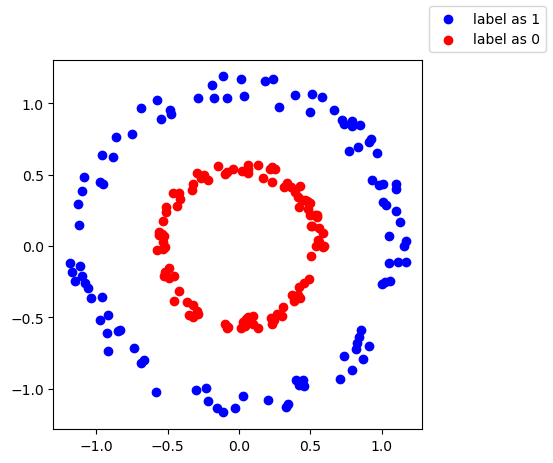

In [3]:
#Create the a dummy data for training
fig, ax = plt.subplots()
ax.set_aspect(aspect='equal')

radius = 1
num_point = 100
np_noise = np.random.rand(num_point)/5+1
np_radian_range = np.linspace(0,2*np.pi,num_point)*np_noise
np_x = np.cos(np_radian_range)*(radius*np_noise)
np_y = np.sin(np_radian_range)*(radius*np_noise)
data_positive = np.stack((np_x,np_y)).T #zip x,y cordinate as model input
label_positive = np.ones(len(data_positive)) #coresponding label as 1

ax.scatter(np_x,np_y,c = 'b')

radius = 0.5
num_point = 100
np_noise = np.random.rand(num_point)/5+1
np_radian_range = np.linspace(0,2*np.pi,num_point)*np_noise
np_x = np.cos(np_radian_range)*(radius*np_noise)
np_y = np.sin(np_radian_range)*(radius*np_noise) 
data_negative = np.stack((np_x,np_y)).T #zip x,y cordinate as model inpout
label_negative = np.zeros(len(data_negative)) #coresponding label as 0

ax.scatter(np_x,np_y, c = 'r')
fig.legend(['label as 1', 'label as 0'])

In [4]:
#prepare training data
train_data = np.concatenate((data_positive, data_negative))
train_label = np.concatenate((label_positive, label_negative))
train_label = train_label[:,np.newaxis] #expend dimension for training
#shuffle the data in the same order
shuffle_order = np.random.permutation(len(train_label))
train_data = train_data[shuffle_order,:]
train_label = train_label[shuffle_order,:]

In [7]:
#create model using keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
model = Sequential([
    layers.Dense(32,activation = 'relu', input_shape = (2,)),
    layers.Dense(32,activation = 'relu'),
    layers.Dense(1,activation = 'sigmoid')
])
model.build()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [6]:
def show_process(count, loss_train, loss, data, label, model, range_tuple, interval, save_fig = False):
    xx,yy = np.meshgrid(np.arange(range_tuple[0][0],range_tuple[0][1],interval),np.arange(range_tuple[1][0],range_tuple[1][1],interval))
    z = model(np.c_[xx.ravel(), yy.ravel()], training =False)
    z = z.numpy()
    z = z.reshape(xx.shape)
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    time.sleep(pause_t)
    loss_train.append(loss.numpy())
    ax.plot(loss_train)
    ax.set_xlim([0,120])
    ax.set_ylim([0,1])
    ax.set_xlabel('Number of epoch')
    ax.set_ylabel('Loss')
    if save_fig == True:
        plt.savefig('a_'+str(count)+'.jpg')
    plt.show()

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)
    ax.set_aspect(aspect='equal')
    im = ax.contourf(xx,yy,z, vmin = 0, vmax = 1, levels = 100, cmap = plt.cm.RdBu)
    cbar = fig.colorbar(im, ax = ax, ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0','0.25','0.5','0.75','1'])
    plt.scatter(data[label == 0,0],data[label == 0,1], c = 'r')
    plt.scatter(data[label == 1,0],data[label == 1,1], c = 'b')
    plt.axis('off')
    if save_fig == True:
        plt.savefig(str(count)+'.jpg')
    plt.show()
    

In [142]:
a = np.arange(10)
b = np.arange(10)
c = np.vstack((a,b))
c.shape

(2, 10)

In [158]:
xx,yy = np.meshgrid(np.arange(-1.5, 1.5, -0.01), np.arange(-1.5, 1.5, 0.01))
xx.shape

(300, 0)

In [164]:
import time
from IPython.display import clear_output
#Customed training loop
pause_t = 0 #slow down the training loop for observation
data_size = len(train_data)
num_epoch = 10 #how many times to go through the training data
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=False)
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
loss_train = [] #use list to collect loss change from each descent step
batch_size = 20 #how many data send for gradient descent in each step
count = 0
xx,yy = np.meshgrid(np.arange(-1.5, 1.5, 0.01), np.arange(-1.5, 1.5, 0.01))
collect_conture = []

model = Sequential([
    layers.Dense(32,activation = 'relu', input_shape = (2,)),
    layers.Dense(32,activation = 'relu'),
    layers.Dense(1,activation = 'sigmoid')
])

for epoch in range(num_epoch):
    for i in range(0, data_size, batch_size): #chop up data in batch for each gradient step
        input = train_data[i:i+batch_size,:]
        target = train_label[i:i+batch_size,:] #ground truth
        with tf.GradientTape() as tape: #use tf.GradientTape to track the gradient
            prediction = model(input, training=True)
            loss = loss_func(y_true = target, y_pred = prediction)
            grads = tape.gradient(loss, model.trainable_variables)
            #one step of graidnet decent
        optimizer.apply_gradients(zip(grads, model.trainable_variables))  
        z = model(np.c_[xx.ravel(), yy.ravel()], training =False)
        z = z.numpy()
        z = z.reshape(xx.shape)
        collect_conture.append(z)
record_conture = np.stack(collect_conture, axis = 2)

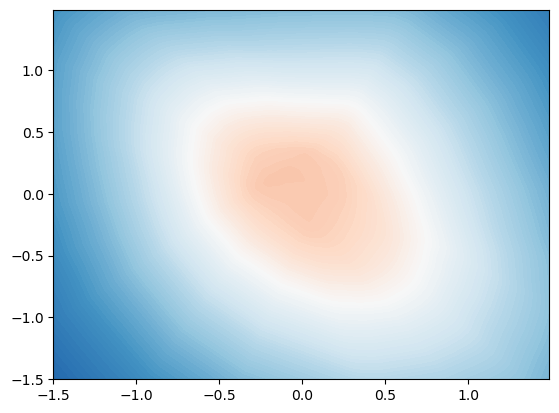

In [168]:
fig, ax = plt.subplots()
def animate(frame_num):
    ct = ax.contourf(xx,yy,record_conture[:,:,frame_num], vmin = 0, vmax = 1, levels = 100, cmap = plt.cm.RdBu)
anim = animation.FuncAnimation(fig, animate, frames=100, interval=20)
anim.save('training.gif')
plt.show()

In [ ]:

def train_model(i):
    xx,yy = np.meshgrid(np.arange(-1.5,1.5,0.01),np.arange(-1.5,1.5,0.01))
    num_steps = int(data_size/batch_size)
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    learning_rate = 0.1
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    label = train_label[:,0]
    input = train_data[i:i+batch_size,:]
    target = train_label[i:i+batch_size,:] #ground truth
    with tf.GradientTape() as tape: #use tf.GradientTape to track the gradient
        prediction = model(input, training=True)
        loss = loss_func(y_true = target, y_pred = prediction)
        grads = tape.gradient(loss, model.trainable_variables)
        #one step of graidnet decent
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  
    #==============show the training process==============
    z = model(np.c_[xx.ravel(), yy.ravel()], training =False)
    z = z.numpy()
    z = z.reshape(xx.shape)
    im = ax.contourf(xx,yy,z, vmin = 0, vmax = 1, levels = 100, cmap = plt.cm.RdBu)
    ax.scatter(train_data[label == 0,0],train_data[label == 0,1], c = 'r')
    ax.scatter(train_data[label == 1,0],train_data[label == 1,1], c = 'b')
    
        

In [6]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 50
%matplotlib notebook

In [ ]:
#https://stackoverflow.com/questions/39472017/how-to-animate-the-colorbar-in-matplotlib

KeyboardInterrupt: 

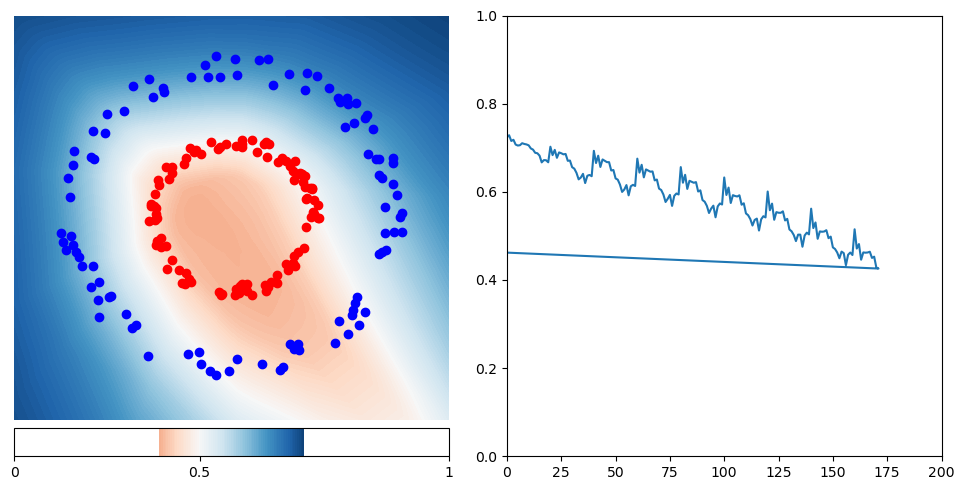

In [140]:
# Enable interactive plot
from IPython import display
import matplotlib.animation as animation
from IPython import display
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
model = Sequential([
    layers.Dense(32,activation = 'relu', input_shape = (2,)),
    layers.Dense(32,activation = 'relu'),
    layers.Dense(1,activation = 'sigmoid')
])
fig, (ax_cont, ax_loss) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
ax_cont.set_axis_off()
collect_loss = []
collect_t = []
ax_cont_divider = make_axes_locatable(ax_cont)
# Add an Axes to the right of the main Axes.
ax_cbar = ax_cont_divider.append_axes("bottom", size="7%", pad="2%")

label = train_label[:,0]
def animate(frame_num):
    # num_steps = int(data_size/batch_size)
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    learning_rate = 0.1
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    i = frame_num%20
    epoch = int(frame_num/20)
    batch_size = 20
    input = train_data[i:i+batch_size,:]
    target = train_label[i:i+batch_size,:] #ground truth
    with tf.GradientTape() as tape: #use tf.GradientTape to track the gradient
        prediction = model(input, training=True)
        loss = loss_func(y_true = target, y_pred = prediction)
        grads = tape.gradient(loss, model.trainable_variables)
        #one step of graidnet decent
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    collect_loss.append(loss)  
    #==============show the training process==============
    #draw distribution of model output
    z = model(np.c_[xx.ravel(), yy.ravel()], training =False)
    z = z.numpy()
    z = z.reshape(xx.shape)
    # im.set_data(z)
    ax_cbar.cla()
    ct = ax_cont.contourf(xx,yy,z, vmin = 0, vmax = 1, levels = 100, cmap = plt.cm.RdBu)
    cbar = fig.colorbar(ct, cax= ax_cbar, ax = ax_cont, orientation='horizontal', shrink=1)
    ax_cbar.set_xticks([0,0.5,1])
    cbar.ax.set_xticklabels(['0', '0.5', '1']) 
    ax_cont.scatter(train_data[label == 0,0],train_data[label == 0,1], c = 'r')
    ax_cont.scatter(train_data[label == 1,0],train_data[label == 1,1], c = 'b')
    #draw loss 
    collect_t.append(frame_num)
    ax_loss.clear()
    ax_loss.plot(collect_t,collect_loss)
    ax_loss.set_ylim([0,1])
    ax_loss.set_xlim([0,200])
    
anim = animation.FuncAnimation(fig, animate, frames=200, interval=20)
display.HTML(anim.to_jshtml())